In [78]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
pd.options.mode.chained_assignment = None  # default='warn'

In [79]:
# Join entre Stress e Feedbacks

feedbacks = pd.read_csv("Feedbacks.csv", parse_dates=['created_date'])
stress = pd.read_csv("Stress.csv", parse_dates=['created_date'])

stress_sid = stress[pd.notna(stress['session_id'])] # pega os que tem session_id preenchido
stress_email = stress[pd.notna(stress['email'])] # pega os que tem email preenchido
stress_email = stress_email[ ~stress_email['session_id'].isin(stress_sid['session_id']) ] # pega os que tem email sem session_id
stress_final = pd.concat([stress_sid, stress_email])

feedbacks_stress = pd.merge(feedbacks, stress_final, on=['session_id', 'email'], how='inner')
feedbacks_stress.drop(columns = ['created_date_y', 'num_sessao_y'], inplace=True)
feedbacks_stress.rename(index=str, columns={'created_date_x':'created_date', 'num_sessao_x':'num_sessao', 'id_x':'id', 'justificativa_x':'justificativa'}, inplace=True)

feedbacks_stress = feedbacks_stress.loc[feedbacks_stress['num_video_preferido'] > 0]

In [80]:
#normaliza os dados da versao 1 para range de 5
def normalize_v1(feedbacks):
    feedbacks.loc[feedbacks['versao'] == 1, ['incomodo', 'interesse1', 'interesse2'] ] //= 2
    return feedbacks

feedbacks_stress = normalize_v1(feedbacks_stress)

In [81]:
# inversao dos valores das sessoes que tem o primeiro video com QoS alta

def swap_ints(feedbacks):
    feedbacks = feedbacks.reset_index(drop=True)

    for i in range(len(feedbacks.index)):
        if feedbacks.loc[i, 'created_date'].month < 7:
            if feedbacks.loc[i]['num_sessao'] in (1, 3, 6):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']
                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1                   
        else:

            if feedbacks.loc[i, 'num_sessao'] in (1, 5):
                feedbacks.at[i, 'interesse1'], feedbacks.at[i, 'interesse2'] = feedbacks.at[i, 'interesse2'], feedbacks.at[i, 'interesse1']

                if feedbacks.at[i, 'num_video_preferido'] == 1:
                    feedbacks.at[i, 'num_video_preferido'] = 2
                else:
                    feedbacks.at[i, 'num_video_preferido'] = 1
    return feedbacks

feedbacks_stress = swap_ints(feedbacks_stress)
feedbacks_stress.replace(np.nan, '', regex=True, inplace=True)
backup_df = feedbacks_stress

In [112]:
#Lista de palavras
low_quality = ['falhas', 'falha', 'interrupção', 'qualidade ruim', 'ruim', 'problema', 'travas', 'travando', 'qualidade baixa', 'baixa', 'pior', 'buffering']

high_quality = ['qualidade', 'sem interrupção', 'sem interrupções', 'não teve interrupção', 'não teve interrupções', 'imagem', 'nítida', 'fluidez',
				 'sem cortes', 'no interrupts', 'no interruptions', 'menos falhas', 'atrapalham', 'continuidade']

cool_content = ['história', 'conteúdo', 'melhor conteúdo', 'engraçado', 'legal', 'relevante', 'criativo', 'gostei', 'visual melhor', 'bonito',
				 'curioso', 'atraente', 'envolvente', 'graça', 'beleza',  'gosto mais', 'gosto', 'interessante', 'interesse', 'emocionante', 'vibrante',
				 'tema', 'impressionante', 'legal', 'dinâmico', 'atrativo', 'informativo']

boring_content = ['monótono', 'menos interessante', 'repetitivo', 'chato', 'entediante', 'sem graça', 'básico']

palavras = [low_quality, high_quality, cool_content, boring_content]

In [113]:
#Cria o dataframe que vai receber os novos parametros
df_text = pd.DataFrame(columns = ['low_quality', 'high_quality', 'cool_content', 'boring_content'],
                       index=range(0,feedbacks_stress.shape[0])).replace(np.nan, 0, regex=True)

In [119]:
#Adicionar informações extraídas do texto

#Restaura dataframe ao estado anterior
feedbacks_stress = backup_df

for i in range (len(feedbacks_stress)):
    for j in range (len(palavras)):
        for k in range (len(palavras[j])):
            if ((palavras[j][k] in feedbacks_stress.iloc[i]['justificativa']) == True):
                if(j==0): df_text.iloc[i]['low_quality'] = 1
                if(j==1): df_text.iloc[i]['high_quality'] = 1
                if(j==2): df_text.iloc[i]['cool_content'] = 1
                if(j==3): df_text.iloc[i]['boring_content'] = 1
                    
feedbacks_stress = pd.concat([feedbacks_stress, df_text], axis=1)

In [114]:
#Adicionar informações extraídas do texto utilizando bigrama
from nltk import bigrams

#Restaura dataframe ao estado anterior
feedbacks_stress = backup_df

for i in range (len(feedbacks_stress)):
    feed_bigram = feedbacks_stress.iloc[i]['justificativa'].split() + [
        ' '.join(i) for i in list(bigrams(feedbacks_stress.iloc[i]['justificativa'].split()))]
    for j in range (len(palavras)):
        for k in range (len(palavras[j])):
            if ((palavras[j][k] in feed_bigram) == True):
                if(j==0): df_text.iloc[i]['low_quality'] = 1
                if(j==1): df_text.iloc[i]['high_quality'] = 1
                if(j==2): df_text.iloc[i]['cool_content'] = 1
                if(j==3): df_text.iloc[i]['boring_content'] = 1
                    
feedbacks_stress = pd.concat([feedbacks_stress, df_text], axis=1)

In [120]:
#estatisticas basicas
feedbacks_stress['dif_interesses'] = (feedbacks_stress['interesse1'] - feedbacks_stress['interesse2'])
feedbacks_stress[['num_sessao', 'num_video_preferido', 'incomodo', 'interesse1', 'interesse2', 'dif_interesses', 'estresse']].describe()

# print(feedbacks_stress.loc[7, ['incomodo', 'interesse1', 'interesse2', 'num_video_preferido', 'justificativa']])

,num_sessao,num_video_preferido,incomodo,interesse1,interesse2,dif_interesses,estresse
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,4.109726,1.503741,3.690773,3.254364,2.678304,0.576060,7.087282
std,2.064686,0.500611,1.262592,1.391092,1.561651,1.623215,2.348375
min,1.000000,1.000000,0.000000,0.000000,0.000000,-5.000000,1.000000
25%,2.000000,1.000000,3.000000,2.000000,1.000000,0.000000,6.000000
50%,4.000000,2.000000,4.000000,4.000000,3.000000,0.000000,8.000000
75%,6.000000,2.000000,5.000000,4.000000,4.000000,2.000000,9.000000
max,7.000000,2.000000,5.000000,5.000000,5.000000,5.000000,10.000000


In [ ]:
# normalized_df = pd.DataFrame(columns=feedbacks_stress.columns)
# feeds = feedbacks_stress
# for i in range(len(feeds)):
#     if ( type(feeds.iloc[i]['session_id']) == str ): # os que tem session_id
        
#         if (feeds.iloc[i]['session_id'] not in normalized_df['session_id'].values):
#             usr_data = feeds[ feeds['session_id'] == feeds.iloc[i]['session_id'] ]
#             mean_int1 = np.mean(usr_data['interesse1'])
#             mean_int2 = np.mean(usr_data['interesse2'])
#             mean_inc = np.mean(usr_data['incomodo'])
#             usr_data['interesse1'] -= mean_int1
#             usr_data['interesse2'] -= mean_int2
#             usr_data['incomodo'] -= mean_inc
#             normalized_df = normalized_df.append(usr_data)
#     else: #so tem email
#         if (feeds.iloc[i]['email'] not in normalized_df['email'].values):
#             usr_data = feeds [ feeds['email'] == feeds.iloc[i]['email'] ]
#             mean_int1 = np.mean(usr_data['interesse1'])
#             mean_int2 = np.mean(usr_data['interesse2'])
#             mean_inc = np.mean(usr_data['incomodo'])
#             usr_data['interesse1'] -= mean_int1
#             usr_data['interesse2'] -= mean_int2
#             usr_data['incomodo'] -= mean_inc
#             normalized_df = normalized_df.append(usr_data)
            
# normalized_df.describe()

In [ ]:
# from sklearn import svm
# from sklearn.model_selection import train_test_split

# X = np.array([ feedbacks_stress['interesse1'], feedbacks_stress['interesse2'],
#               feedbacks_stress['incomodo'], feedbacks_stress['mais'], feedbacks_stress['interessante'],
#               feedbacks_stress['conteúdo'], feedbacks_stress['não'], feedbacks_stress['qualidade'], feedbacks_stress['falhas']
#              ]).transpose()


# # X = np.array([ normalized_df['interesse1'], normalized_df['interesse2'], normalized_df['incomodo'] ]).transpose()
# y = feedbacks_stress['num_video_preferido']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42)

# clf = svm.SVC()
# clf.fit(X_train, y_train)

# y_predicted = clf.predict(X_test)

# accuracy_score(y_test, y_predicted)


In [ ]:
# grafico (interessev1 x preferencia/escolha usuario)

counts = feedbacks_stress.groupby(['interesse1','num_video_preferido'], as_index=False).size().unstack(fill_value=0).reset_index()
counts['V1_percent'] = round(counts[1]/(counts[1]+counts[2]), 2)
counts['V2_percent'] = round(counts[2]/(counts[1]+counts[2]), 2)

ax = plt.subplot()
b1 = ax.bar(counts['interesse1']-0.2, counts['V1_percent'],width=0.2,color='b',align='center')
b2 = ax.bar(counts['interesse1'], counts['V2_percent'],width=0.2,color='g',align='center')


leg = plt.legend((b1[0], b2[0]), ('V1', 'V2'), loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.2
bb.x0 += xOffset
bb.x1 += xOffset

leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.ylabel('Frequencia')
plt.xlabel('InteresseVideo1')


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(b1, "left")
autolabel(b2, "right")
plt.show()

In [77]:
# teste pareado
from math import sqrt
dif_interesses = feedbacks_stress['dif_interesses']
n = len(dif_interesses)

mean = np.mean(dif_interesses)
std = np.std(dif_interesses)

std_amostral = std/sqrt(n)

T = mean/(std_amostral)
T

7.115510445190759

0.910224438903


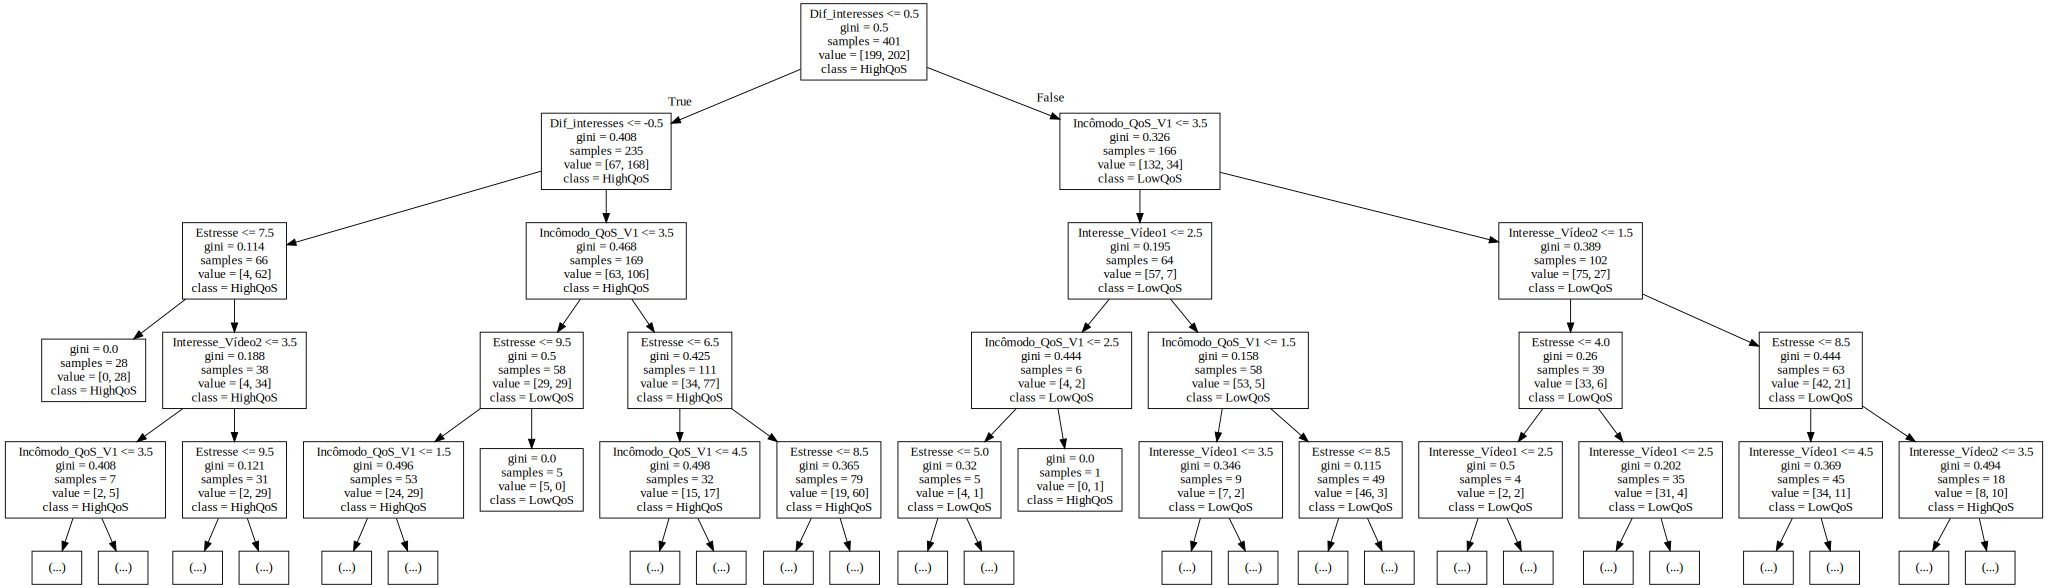

In [181]:
#Arvore de decisao
def arvore(feedbacks, features = ['incomodo', 'interesse1', 'interesse2', 'dif_interesses'],
           feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses'],
           stress=False):
    
#     clf = tree.DecisionTreeClassifier(min_samples_leaf=38)
    clf = tree.DecisionTreeClassifier()
    
    X = []
    for feature in features:
        X.append(feedbacks[feature])
    X = np.array(X).transpose()

    if stress:
        feature_names.append('Estresse')
        X = np.append(X, np.array(feedbacks['estresse']).reshape(-1, 1), axis=1)
        
    Y = np.array(feedbacks['num_video_preferido'])
       
        
    clf.fit(X, Y)
    
    predicted = clf.predict(X)
    print(accuracy_score(Y, predicted))
    
    dot_data = tree.export_graphviz(clf,
                                    feature_names=feature_names,
                                    max_depth=4,
                                    class_names=['LowQoS', 'HighQoS'],
                                    out_file=None) 
    graph = graphviz.Source(dot_data)
#     graph.render("arvore_0108_musica")
    return graph



graph = arvore(feedbacks_stress, stress=True)

graph

Acurácia Treinamento: 0.978571428571
Acurácia Teste: 0.710743801653


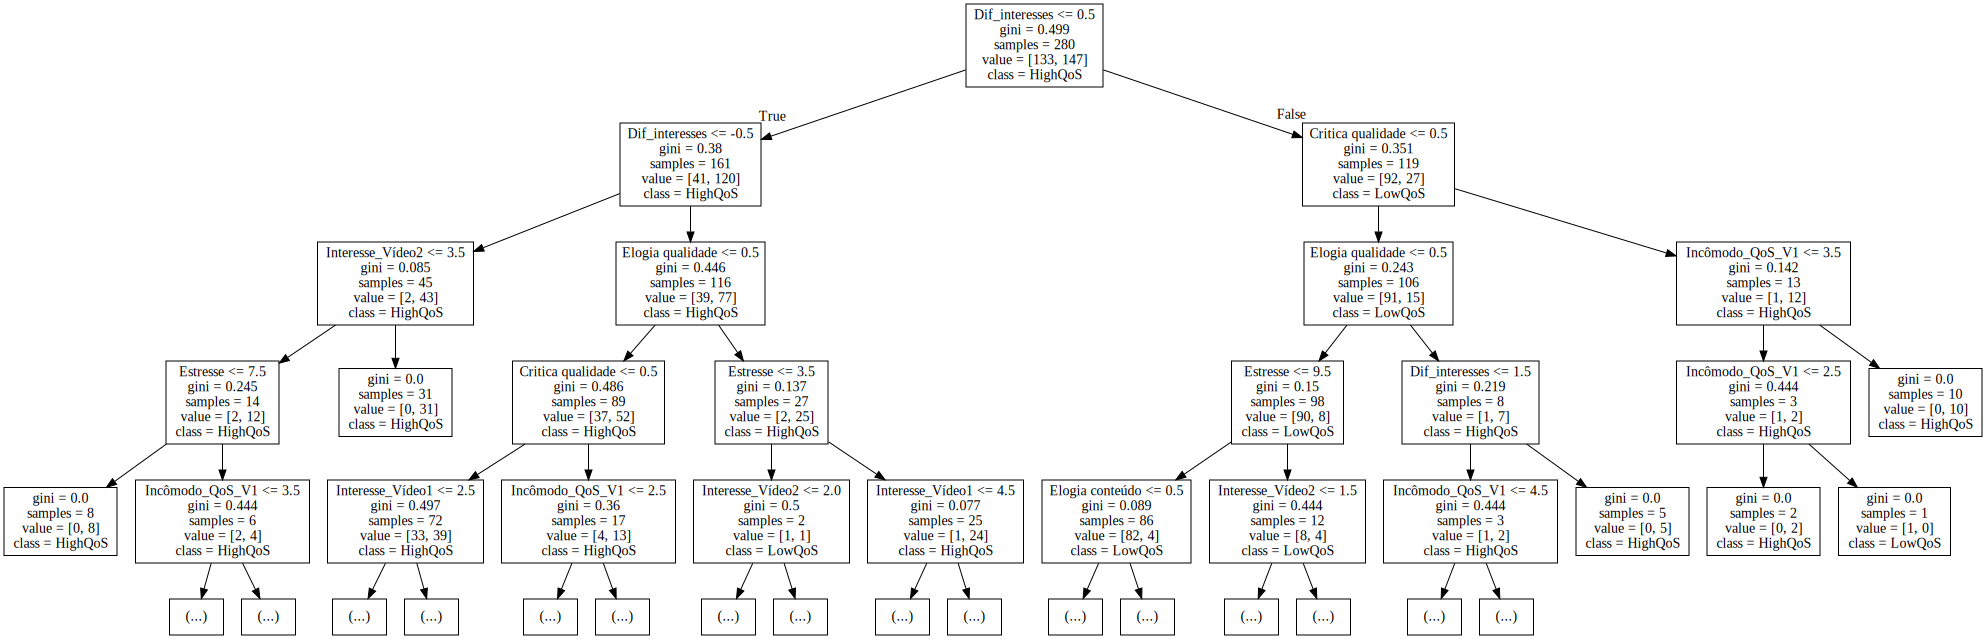

In [180]:
#Arvore de decisao Teste / Treinamento
from sklearn.model_selection import train_test_split

def arvore(feedbacks, features = ['incomodo', 'interesse1', 'interesse2', 'dif_interesses',
                                  'low_quality', 'high_quality', 'cool_content', 'boring_content'],
           feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses',
                           'Critica qualidade', 'Elogia qualidade', 'Elogia conteúdo', 'Critica conteúdo'],
           stress=False):
    
#     clf = tree.DecisionTreeClassifier(min_samples_leaf=38)
    clf = tree.DecisionTreeClassifier()
    
    #Teste
    
    X = []
    for feature in features:
        X.append(feedbacks[feature])
    X = np.array(X).transpose()

    if stress:
        feature_names.append('Estresse')
        X = np.append(X, np.array(feedbacks['estresse']).reshape(-1, 1), axis=1)
        
    Y = np.array(feedbacks['num_video_preferido'])
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=12345)
        
    clf.fit(x_train, y_train)
    
    print("Acurácia Treinamento: " + str(accuracy_score(y_train, clf.predict(x_train))))
    print("Acurácia Teste: " + str(accuracy_score(y_test, clf.predict(x_test))))

    
    dot_data = tree.export_graphviz(clf,
                                    feature_names=feature_names,
                                    max_depth=4,
                                    class_names=['LowQoS', 'HighQoS'],
                                    out_file=None) 
    graph = graphviz.Source(dot_data)
#     graph.render("arvore_0108_musica")
    return graph



graph = arvore(feedbacks_stress, stress=True)

graph

In [ ]:
#Testar acurácia da árvore de decisão

In [ ]:
# Analisando categoria dos videos(nao confundir com as reportadas pelos usuarios)

# feeds = pd.read_csv("Feedbacks 17_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
# feeds = normalize_v1(feeds)
# feeds = swap_ints(feeds)

feeds = feedbacks_stress

feeds_per_session_v1 = []
feeds_per_session_v2 = []
for i in range(1, 8):
    f = feeds[feeds['num_sessao'] == i]
    feeds_per_session_v1.append(f[f['created_date'].dt.month < 7])
    feeds_per_session_v2.append(f[f['created_date'].dt.month >= 7])


#Esportes (V1: S1 + S5 ; V2: 1 + 4)
# feeds_esportes = pd.concat([feeds_per_session_v1[0], feeds_per_session_v1[4], feeds_per_session_v2[0], feeds_per_session_v2[3]])
# arvore(feeds_esportes, stress=True)

# Comedia (V1: 2; V2: 2)
# feeds_comedia = pd.concat([feeds_per_session_v1[1], feeds_per_session_v2[1]])
# arvore(feeds_comedia, stress=True)

# Animais (V1: 4, 6; V2: 3, 5)
# feeds_animais = pd.concat([feeds_per_session_v1[3], feeds_per_session_v1[5], 
#                             feeds_per_session_v2[2], feeds_per_session_v2[4]])
# arvore(feeds_animais, stress=True)

# Documentario(V1: 6, 7; V2: 5, 6 )
# feeds_docs = pd.concat([feeds_per_session_v1[5], feeds_per_session_v1[6], 
#                             feeds_per_session_v2[4], feeds_per_session_v2[5]])
# arvore(feeds_docs, stress=True)

# # Musica (V2 apenas: S7)
# feeds_musica = feeds_per_session_v2[6]
# arvore(feeds_musica, stress=True)

In [ ]:
# Analisando as categorias <reportadas> pelos usuários

categories = pd.read_csv("Categorias 01_08 - video_sessions_categories.csv", parse_dates=['created_date'])


categories_sid = categories[pd.notna(categories['session_id'])]

feeds_categ = pd.merge(feedbacks_stress, categories_sid, on='session_id', how='inner') #join
feeds_categ = feeds_categ.reset_index(drop=True)
feeds_categ['categoria_pos'] = np.zeros(len(feeds_categ))

for i in range(len(feeds_categ)):
    f = feeds_categ.iloc[i]
    categs = f.loc[['comedia', 'esporte', 'documentario', 'musica', 'animais']]
    
    categ_sessao = -1
    for j in range(1, 8):
        
        if f['num_sessao'] == 1:
            categ_sessao = 'esporte'
        elif f['num_sessao'] == 2:
            categ_sessao = 'comedia'
        elif f['num_sessao'] == 3:
            categ_sessao = 'animais'
        elif f['num_sessao'] == 4:
            categ_sessao = 'esporte'
        elif f['num_sessao'] == 5:
            categ_sessao = 'documentario'
        elif f['num_sessao'] == 6:
            categ_sessao = 'documentario'
        elif f['num_sessao'] == 7:
            categ_sessao = 'musica'
            
    feeds_categ.at[i, 'categoria_pos'] = categs[categ_sessao]

    
feedbacks = feeds_categ
clf = tree.DecisionTreeClassifier()

feedbacks['dif_interesses'] = abs(feedbacks['interesse1'] - feedbacks['interesse2'])

X = np.array([feedbacks['incomodo'], feedbacks['interesse1'], feedbacks['interesse2'],
              feedbacks['dif_interesses'], feedbacks['estresse'], feedbacks['categoria_pos'] ]).transpose()

Y = np.array(feedbacks['num_video_preferido'])


clf.fit(X, Y)

feature_names = ['IncômodoQoSV1', 'InteresseVídeo1', 'InteresseVídeo2',
                 'DifInteresses', 'Estresse','PrioridCateg']
dot_data = tree.export_graphviz(clf, max_depth=3, feature_names=feature_names,
                                            class_names=['Primeiro', 'Segundo'],out_file=None) 
graph = graphviz.Source(dot_data)
# graph.render("arvore_prior_categ_0108")
graph


In [ ]:
# revertendo a troca das classificacoes para solucionar o problema: (j1, primeiro) -> (j1, segundo)

# feeds = pd.read_csv("Feedbacks 01_08 - video_sessions_feedback.csv", parse_dates=['created_date'])
feeds = feedbacks_stress.copy()

f_v1 = feeds[ feeds['created_date'].dt.month < 7]
f_v2 = feeds[ feeds['created_date'].dt.month >= 7]

highQoS = f_v1[ ( f_v1['num_sessao'].isin([1,3,6]) & (f_v1['num_video_preferido']==1) ) |
               (f_v1['num_sessao'].isin([2,4,5,7]) & (f_v1['num_video_preferido']==2) ) ]

highQoS = pd.concat([ highQoS, 
                    f_v2[( f_v2['num_sessao'].isin([1,5]) & (f_v2['num_video_preferido']==1) ) |
                    ( f_v2['num_sessao'].isin([2,3,4,6,7]) & (f_v2['num_video_preferido']==2) )]
                    ])

lowQoS = feeds[~feeds['id'].isin(highQoS['id'])]

lowQoS['class'] = 'lowQoS'
highQoS['class'] = 'highQoS'

low_high = pd.concat([lowQoS, highQoS])
low_high.describe()

low_high = swap_ints(low_high)
low_high.describe()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
justific = feedbacks_stress[ ['justificativa', 'num_video_preferido'] ].copy()
justific.dropna(inplace=True)
justificativas = justific['justificativa']
# justificativas = justific[justific['num_video_preferido']==2]['justificativa']
# justificativas = lowQoS['justificativa'].dropna()
X = vectorizer.fit_transform(justificativas)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
print(sorted(words_freq, key = lambda x: x[1], reverse=True)[:20])


# # Create the wordcloud object
# wordcloud = WordCloud(width=480, height=480, margin=0).generate(' '.join(justific[justific['num_video_preferido'] == 2]['justificativa_x']))
 
# # Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.show()

In [ ]:
# adiciona colunas das top palavras(palavras mais frequentes para cada classe(highqos e lowqos))

# top words low quality
feedbacks_stress['mais'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['interessante'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['conteúdo'] = np.zeros(len(feedbacks_stress))

# top words high quality
feedbacks_stress['não'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['qualidade'] = np.zeros(len(feedbacks_stress))
feedbacks_stress['falhas'] = np.zeros(len(feedbacks_stress))

In [ ]:
# mutual information
from math import log

def count_doc_freq_series(word, s):
    return sum(1 for i in range(len(s)) if word in s.iloc[i].split())

def mutual_info(t, corpus_class, class_name, c1_name, c2_name, ctxt_name):
    c1 = corpus_class[ corpus_class[class_name] == c1_name]
    c2 = corpus_class[ corpus_class[class_name] == c2_name]
    
    corpus_c1 = " ".join(c1[ctxt_name]).lower().replace("\n", "")
    corpus_c2 = " ".join(c2[ctxt_name]).lower().replace("\n", "")
    n = len(corpus_class)
    n_1 = len(c1)
    n_0 = len(c2)
    n11 = count_doc_freq_series(t, c1['justificativa']) # num de documentos da classe v1 que tem o termo t1
    n10 = count_doc_freq_series(t, c2['justificativa']) # num de documentos que nao sao da classe v1 que tem o termo t1
    if (n11==0 or n10==0):
        return 0
    n01 = n_1 - n11 # num documentos da classe v1 que nao tem o termo t1
    n00 = n_0 - n10 # num documentos que nao sao da classe v1 e nao tem o termo t1
    n1_ = n11 + n10 # num documentos que tem o t1
    n0_ = n01 + n00 # num documentos que nao tem o termo t1
    
#     print("et=1 ec=1 ", n11)
#     print("et=1 ec=0 ", n10)
#     print("et=0 ec=1", n01)
#     print("et=0 ec=0", n00)
    
    I = ( n11/n * log((n*n11)/(n1_*n_1), 2) ) + ( n01/n * log((n*n01)/(n0_*n_1), 2) ) + \
    ( n10/n * log(n*n10/(n1_*n_0), 2) ) + ( n00/n*log(n*n00/(n0_*n_0), 2) )
    
    return I

# justificativa_low_high = low_high[ ['justificativa', 'class'] ]
# justificativa_low_high = justificativa_low_high.dropna()
t1 = "não"
t2 = "qualidade"
t3 = "falhas"

print(mutual_info(t1, justific, 'num_video_preferido', 2, 1, 'justificativa'))
# print(mutual_info(t, justificativa_low_high, 'class', 'lowQoS', 'highQoS', 'justificativa'))


In [ ]:
corpus = justific['justificativa']
corpus = " ".join(corpus).lower().replace("\n", "")
corpus = corpus.split()
corpus = list(set(corpus))

words_mi = {}
for i in corpus:
    words_mi[i] = mutual_info(i, justific, 'num_video_preferido', 1, 2, 'justificativa')
#     print(i+': '+str(mutual_info(i, justific, 'num_video_preferido', 1, 2, 'justificativa')))

sorted(words_mi.items(), key=lambda x:x[1], reverse=True)


In [ ]:
# insere os valores de informacao mutua

index = feedbacks_stress['justificativa'].dropna().index

for i in index:
    
    if feedbacks_stress.loc[i]['num_video_preferido'] == 1:
        if 'mais' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'mais'] = mutual_info('mais', justific, 'num_video_preferido', 1, 2, 'justificativa')
        elif 'interessante' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'interessante'] = mutual_info('interessante', justific, 'num_video_preferido', 1, 2, 'justificativa')
        elif 'conteúdo' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'conteúdo'] = mutual_info('conteúdo', justific, 'num_video_preferido', 1, 2, 'justificativa')

    else:
        if 'não' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'não'] = mutual_info('não', justific, 'num_video_preferido', 2, 1, 'justificativa')
        elif 'qualidade' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'qualidade'] = mutual_info('qualidade', justific, 'num_video_preferido', 2, 1, 'justificativa')
        elif 'falhas' in feedbacks_stress.loc[i]['justificativa']:
            feedbacks_stress.at[i, 'falhas'] = mutual_info('falhas', justific, 'num_video_preferido', 2, 1, 'justificativa')
        

In [ ]:
graph = arvore(feedbacks_stress, features = ['incomodo', 'interesse1', 'interesse2', 'dif_interesses', 'mais', 'interessante', 'conteúdo', 'não', 'qualidade', 'falhas'],
           feature_names = ['Incômodo_QoS_V1', 'Interesse_Vídeo1', 'Interesse_Vídeo2', 'Dif_interesses', 'mais', 'interessante', 'conteúdo', 'não', 'qualidade', 'falhas'])
graph

In [ ]:
df_sessions = []
for i in range(1, 8):
    if i == 1:
        categ_sessao = 'esporte'
    elif i == 2:
        categ_sessao = 'comedia'
    elif i == 3:
        categ_sessao = 'animais'
    elif i == 4:
        categ_sessao = 'esporte'
    elif i == 5:
        categ_sessao = 'documentario'
    elif i == 6:
        categ_sessao = 'documentario'
    elif i == 7:
        categ_sessao = 'musica'
    print(categ_sessao + "\n")
    print(feedbacks_stress[ feedbacks_stress['num_sessao'] == i ][['num_video_preferido', 'incomodo', 'interesse1', 'interesse2']].describe())
    print("\n")

In [ ]:
# Gradient boosting algorithms
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

feedbacks_stress['dif_interesses'] = abs(feedbacks_stress['interesse1'] - feedbacks_stress['interesse2'])


X = np.array([ feedbacks_stress['interesse1'], feedbacks_stress['interesse2'], feedbacks_stress['dif_interesses'],
              feedbacks_stress['incomodo'], feedbacks_stress['estresse'] ]).transpose()
y = feedbacks_stress['num_video_preferido']


clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(clf, X, y)
scores.mean()       

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
     max_depth=5, random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))
scores = cross_val_score(clf, X, y)
print(scores.mean())

print(clf.feature_importances_)

In [ ]:
def gaussian_func(points, use_z = False):
    mu = np.mean(points)
    std = np.std(points)
    
    if use_z:
        z_points = (points - mu) / std
        y_gauss = 1/(np.sqrt(2 * np.pi)) * np.e**(-0.5 * z_points**2)
        return z_points, y_gauss
    else:
        y_gauss = ( 1/(std * np.sqrt(2 * np.pi)) ) * np.e**(-(points-mu)**2/std**2)
        return points, y_gauss

In [ ]:
def gauss_value(points, mu, std):
    y_gauss = ( (1/std* np.sqrt(2**np.pi)) ) * np.e**(-(points-mu)**2/std**2)
    return y_gauss

incomodo = np.array(feedbacks_stress['incomodo'])
x_points = np.sort(incomodo)

# points, y_gauss = gaussian_func(x_points, use_z=False)

mean = np.mean(incomodo)
std = np.std(incomodo)

x_base = np.arange(0, 15)
y_gauss = gauss_value(x_base, mean, std)

plt.plot(incomodo, np.zeros(len(incomodo)), 'ro')
plt.plot(x_base, y_gauss)

In [ ]:
def grid_search_mu_std(array):

    mu_range = np.arange(1, 10, 0.1)
    std_range = np.arange(1, 10, 0.1)

    best_mu = -np.inf
    best_std = -np.inf
    max_likelihood = -np.inf


    for mu_t in mu_range:
        for std_t in std_range:
            y_gauss = gauss_value(array, mu_t, std_t)
            log_likelihood = np.sum(np.log(y_gauss))
            if (log_likelihood - max_likelihood) > 0.00001:
                max_likelihood = log_likelihood
                best_mu = mu_t
                best_std = std_t
    print("Melhor média: ", best_mu)
    print("Melhor std: ", best_std)
    return best_mu, best_std

dif_ints = feedbacks_stress['dif_interesses']
incomodo = feedbacks_stress['incomodo']

In [ ]:
def plot_normal(array):

    mean_a = np.mean(array)
    std_a = np.std(array)

    x_base = np.arange(0, 10)
    y_gauss_inc = gauss_value(x_base, mean_a, std_a)

    mean_opt, std_opt = grid_search_mu_std(array)

    y_gauss_opt = gauss_value(x_base, mean_opt, std_opt)

    plt.plot(x_base, y_gauss_inc, 'b')
    plt.plot(array, np.zeros(len(array)), 'ro')
    plt.plot(x_base, y_gauss_opt, 'r')

# plot_normal(incomodo)
# plot_normal(dif_ints)
# plot_normal(feedbacks_stress['interesse1'])
# plot_normal(feedbacks_stress['interesse2'])
plot_normal(feedbacks_stress['estresse'])

In [ ]:
# prepara para aplicar os algoritmos de ML

label = feedbacks_stress.num_video_preferido
label = label.astype('int').reshape(-1,1)


feedbacks_stress_text = feedbacks_stress.drop(['id', 'email','num_sessao','num_video_preferido', 'created_date', 'comment','published_date', 'english', 'session_id','versao'], axis=1)
feedbacks_stress = feedbacks_stress_text.drop(['justificativa'], axis=1)


In [ ]:
class Results:
    def __init__(self):
        pass
    nb = []
    tree = []
    sgd = []
    lsvc = []
    svc = []
    kmeans = []
    knn = []
    rf = []
    mlp = []
    
def run_algorithms(results, df_data, label):
    #Initialize test and train data
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    x_train, x_test, y_train, y_test = train_test_split(df_data, label, test_size=0.3)
    
    #Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    nb_clf = MultinomialNB().fit(x_train, y_train)
    nb_y_pred = nb_clf.predict(x_test)
    nb_cm = confusion_matrix(y_test, nb_y_pred)
    nb_p1 = precision_score(y_test, nb_y_pred)
    nb_p2 = precision_score(y_test, nb_y_pred, pos_label=2)
    nb_p = precision_score(y_test, nb_y_pred, average='weighted')
    nb_a = accuracy_score(y_test, nb_y_pred)
    nb_r = classification_report(y_test, nb_y_pred)
    results.nb += [[nb_p1, nb_p2, nb_p, nb_a, nb_cm, nb_r]]
    
    #Decision Trees
    from sklearn import tree
    tree_clf = tree.DecisionTreeClassifier().fit(x_train, y_train)
    tree_y_pred = tree_clf.predict(x_test)
    tree_cm = confusion_matrix(y_test, tree_y_pred)
    tree_p1 = precision_score(y_test, tree_y_pred)
    tree_p2 = precision_score(y_test, tree_y_pred, pos_label=2)
    tree_p = precision_score(y_test, tree_y_pred, average='weighted')
    tree_a = accuracy_score(y_test, tree_y_pred)
    tree_r = classification_report(y_test, tree_y_pred)
    results.tree += [[tree_p1, tree_p2, tree_p, tree_a, tree_cm, tree_r]]
    
    
    #Stochastic Gradient Descent
    from sklearn.linear_model import SGDClassifier
    sgd_clf = SGDClassifier(alpha=.000001, n_iter=50000).fit(x_train, y_train)
    sgd_y_pred = sgd_clf.predict(x_test)
    sgd_cm = confusion_matrix(y_test, sgd_y_pred)
    sgd_p1 = precision_score(y_test, sgd_y_pred)
    sgd_p2 = precision_score(y_test, sgd_y_pred, pos_label=2)
    sgd_p = precision_score(y_test, sgd_y_pred, average='weighted')
    sgd_a = accuracy_score(y_test, sgd_y_pred)
    sgd_r = classification_report(y_test, sgd_y_pred)
    results.sgd += [[sgd_p1, sgd_p2, sgd_p, sgd_a, sgd_cm, sgd_r]]
    
    
    #Linear SVC
    from sklearn.svm import LinearSVC
    lsvc_clf = LinearSVC(dual=False, max_iter=10000, tol=1e-6).fit(x_train, y_train)
    lsvc_y_pred = lsvc_clf.predict(x_test)
    lsvc_cm = confusion_matrix(y_test, lsvc_y_pred)
    lsvc_p1 = precision_score(y_test, lsvc_y_pred)
    lsvc_p2 = precision_score(y_test, lsvc_y_pred, pos_label=2)
    lsvc_p = precision_score(y_test, lsvc_y_pred, average='weighted')
    lsvc_a = accuracy_score(y_test, lsvc_y_pred)
    lsvc_r = classification_report(y_test,lsvc_y_pred)
    results.lsvc += [[lsvc_p1, lsvc_p2, lsvc_p, lsvc_a, lsvc_cm, lsvc_r]]
    
    
    #SVC
    from sklearn.svm import SVC
    svc_clf = SVC(cache_size=2000, probability = True).fit(x_train, y_train)
    svc_y_pred = svc_clf.predict(x_test)
    svc_cm = confusion_matrix(y_test, svc_y_pred)
    svc_p1 = precision_score(y_test, svc_y_pred)
    svc_p2 = precision_score(y_test, svc_y_pred, pos_label=2)
    svc_p = precision_score(y_test, svc_y_pred, average='weighted')
    svc_a = accuracy_score(y_test, svc_y_pred)
    svc_r = classification_report(y_test,svc_y_pred) 
    results.svc += [[svc_p1, svc_p2, svc_p, svc_a, svc_cm, svc_r]]
    

    
    #KNN Classifier
    from sklearn.neighbors import KNeighborsClassifier
    knn_clf = KNeighborsClassifier(n_neighbors=15).fit(x_test, y_test)
    knn_y_pred = knn_clf.predict(x_test)
    knn_cm = confusion_matrix(y_test, knn_y_pred)
    knn_p1 = precision_score(y_test, knn_y_pred)
    knn_p2 = precision_score(y_test, knn_y_pred, pos_label=2)
    knn_p = precision_score(y_test, knn_y_pred, average='weighted')
    knn_a = accuracy_score(y_test, knn_y_pred)
    knn_r = classification_report(y_test, knn_y_pred)
    results.knn += [[knn_p1, knn_p2, knn_p, knn_a, knn_cm, knn_r]]
    
    #Random Forest Algorithm
    from sklearn.ensemble import RandomForestClassifier 
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
    rf_y_pred = rf_clf.predict(x_test)
    rf_cm = confusion_matrix(y_test, rf_y_pred)
    rf_p1 = precision_score(y_test, rf_y_pred)
    rf_p2 = precision_score(y_test, rf_y_pred, pos_label=2)
    rf_p = precision_score(y_test, rf_y_pred, average='weighted')
    rf_a = accuracy_score(y_test, rf_y_pred)
    rf_r = classification_report(y_test, rf_y_pred)
    results.rf += [[rf_p1, rf_p2, rf_p, rf_a, rf_cm, rf_r]]
    
    
    #Neural Network
    from sklearn.neural_network import MLPClassifier
    mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,150), max_iter=1000).fit(x_train, y_train)
    mlp_y_pred = mlp_clf.predict(x_test)
    mlp_cm = confusion_matrix(y_test, mlp_y_pred)
    mlp_p1 = precision_score(y_test, mlp_y_pred)
    mlp_p2 = precision_score(y_test, mlp_y_pred, pos_label=2)
    mlp_p = precision_score(y_test, mlp_y_pred, average='weighted')
    mlp_a = accuracy_score(y_test, mlp_y_pred)
    mlp_r = classification_report(y_test, mlp_y_pred)
    results.mlp += [[mlp_p1, mlp_p2, mlp_p, mlp_a, mlp_cm, mlp_r]]
    
    return results

def print_results(results):
    #Write to file
    writer = pd.ExcelWriter('output.xlsx')
    df_nb = pd.DataFrame(data=results.nb, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_tree = pd.DataFrame(data=results.tree, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_sgd = pd.DataFrame(data=results.sgd, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_lsvc = pd.DataFrame(data=results.lsvc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_svc = pd.DataFrame(data=results.svc, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_knn = pd.DataFrame(data=results.knn, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_rf = pd.DataFrame(data=results.rf, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    df_mlp = pd.DataFrame(data=results.mlp, columns = ['Precision(1)', 'Precision(2)', 'Precision(Avg)', 'Accuracy', 'ConfusionMatrix', 'Summary'])
    
    writer = pd.ExcelWriter('output.xlsx')
    df_nb.to_excel(writer,'Naive Bayes')
    df_tree.to_excel(writer,'Decision Tree')
    df_sgd.to_excel(writer,'Stochastic Gradient Descent')
    df_lsvc.to_excel(writer,'Linear SVC')
    df_svc.to_excel(writer,'Support Vector Classification')
    df_knn.to_excel(writer,'K-Nearest Neighbors')
    df_rf.to_excel(writer,'Random Forest')
    df_mlp.to_excel(writer,'Multi Layer Perceptron')

    writer.save()
    

In [ ]:
#Main():
container = Results()
for i in range(10):
    container = run_algorithms(container, feedbacks_stress, label)
    
print_results(container)

In [ ]:
for i in (feedbacks.justificativa):
    print(i)